In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scorecardpy as sc

In [21]:
# Load your dataset (replace 'your_file.csv' with your actual file path)
df = pd.read_csv('../data/proccessed/cleaned_data.csv')

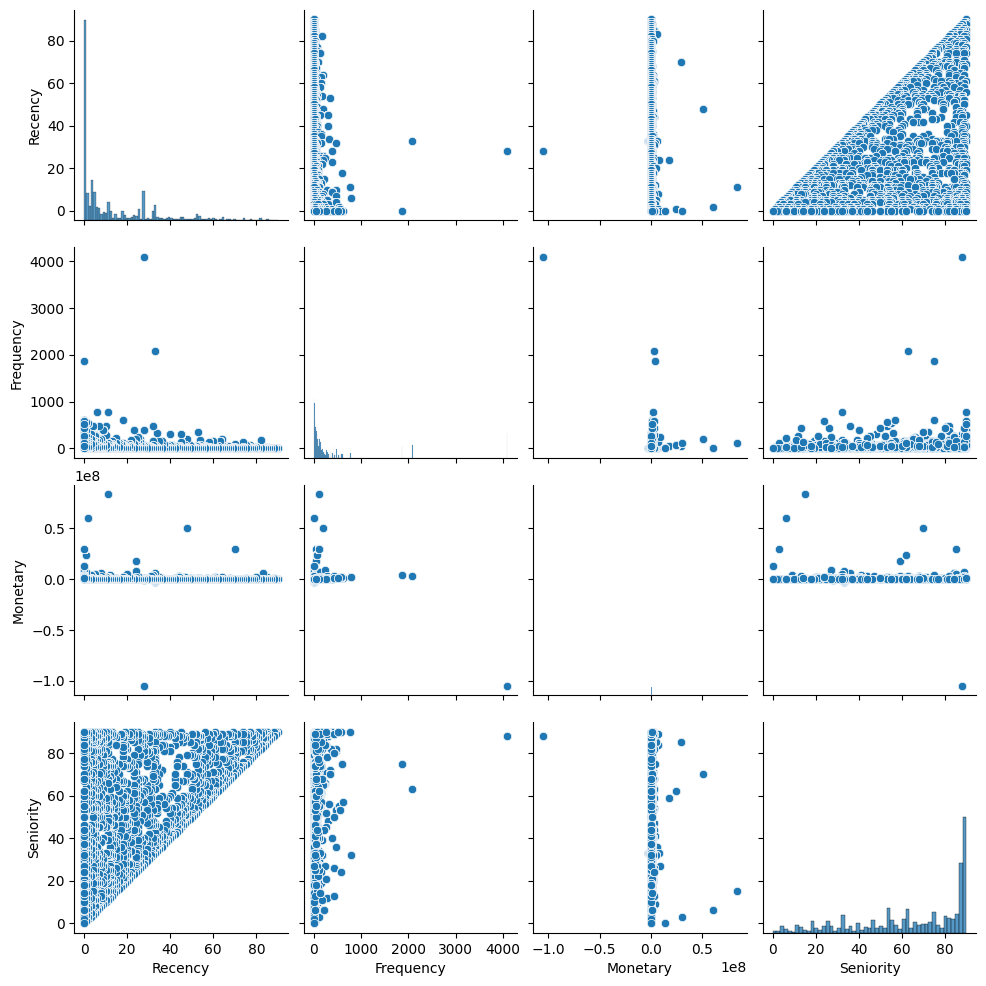

In [22]:
# 1. Constructing a Default Estimator using RFMS formalism
# Convert 'TransactionStartTime' to datetime
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], errors='coerce')

# Create RFMS features
# Recency: Days since the last transaction
df['Recency'] = (df['TransactionStartTime'].max() - df.groupby('CustomerId')['TransactionStartTime'].transform('max')).dt.days

# Frequency: Total number of transactions per customer
df['Frequency'] = df.groupby('CustomerId')['TransactionId'].transform('count')

# Monetary: Total transaction amount per customer
df['Monetary'] = df.groupby('CustomerId')['Amount'].transform('sum')

# Seniority: Days since the first transaction (engagement duration)
df['Seniority'] = (df['TransactionStartTime'].max() - df.groupby('CustomerId')['TransactionStartTime'].transform('min')).dt.days

# Visualize the RFMS features in pair plots to check distribution
sns.pairplot(df[['Recency', 'Frequency', 'Monetary', 'Seniority']])
plt.show()

In [23]:
# Assign Good/Bad Labels Based on RFMS Score


# Calculate RFMS score by multiplying features (adjust the logic based on your understanding)
df['RFMS_Score'] = df['Recency'] * df['Frequency'] * df['Monetary'] * df['Seniority']

# Define a threshold to classify users as 'good' or 'bad'
# Adjust the threshold based on your RFMS analysis (visualize to understand the distribution first)
threshold = df['RFMS_Score'].quantile(0.5)  # You can adjust this threshold
df['RiskLabel'] = df['RFMS_Score'].apply(lambda x: 'bad' if x < threshold else 'good')

# Check the distribution of good and bad users
display(df['RiskLabel'].value_counts())

RiskLabel
good    47833
bad     47829
Name: count, dtype: int64

In [24]:
# 2. Perform WoE Binning

# Perform WoE binning for RFMS features
features_to_bin = ['Recency', 'Frequency', 'Monetary', 'Seniority']

# WoE binning for RFMS features based on 'RiskLabel'
bins = sc.woebin(df, y='RiskLabel', x=features_to_bin)

# Apply WoE binning to the dataset
df_woe = sc.woebin_ply(df, bins)

# View the transformed dataset with WoE features
display(df_woe.head())

[INFO] creating woe binning ...


C:\Users\michael\AppData\Roaming\Python\Python313\site-packages\scorecardpy\condition_fun.py:141: UserWarning: The positive value in "RiskLabel" was replaced by 1 and negative value by 0.
  warnings.warn("The positive value in \"{}\" was replaced by 1 and negative value by 0.".format(y))
C:\Users\michael\AppData\Roaming\Python\Python313\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
C:\Users\michael\AppData\Roaming\Python\Python313\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd

[INFO] converting into woe values ...


,ProductId,Amount,CurrencyCode,ChannelId,TransactionStartTime,Value,FraudResult,PricingStrategy,RFMS_Score,BatchId,...,ProviderId,SubscriptionId,RiskLabel,AccountId,ProductCategory,TransactionId,Recency_woe,Seniority_woe,Monetary_woe,Frequency_woe
0,ProductId_10,1000.0,UGX,ChannelId_3,2018-11-15 02:18:49+00:00,1000,0,2,0.000000e+00,BatchId_36123,...,ProviderId_6,SubscriptionId_887,bad,AccountId_3957,airtime,TransactionId_76871,1.640228,-0.365797,-0.743699,-0.639772
1,ProductId_6,-20.0,UGX,ChannelId_2,2018-11-15 02:19:08+00:00,20,0,2,0.000000e+00,BatchId_15642,...,ProviderId_4,SubscriptionId_3829,bad,AccountId_4841,financial_services,TransactionId_73770,1.640228,-0.365797,-0.743699,-0.639772
2,ProductId_1,500.0,UGX,ChannelId_3,2018-11-15 02:44:21+00:00,500,0,2,1.458000e+07,BatchId_53941,...,ProviderId_6,SubscriptionId_222,bad,AccountId_4229,airtime,TransactionId_26203,-0.387976,-0.365797,1.199178,1.481383
3,ProductId_21,20000.0,UGX,ChannelId_3,2018-11-15 03:32:55+00:00,21800,0,2,3.911235e+09,BatchId_102363,...,ProviderId_1,SubscriptionId_2185,good,AccountId_648,utility_bill,TransactionId_380,-0.948951,-0.365797,-0.743699,0.187372
4,ProductId_6,-644.0,UGX,ChannelId_2,2018-11-15 03:34:21+00:00,644,0,2,3.911235e+09,BatchId_38780,...,ProviderId_4,SubscriptionId_3829,good,AccountId_4841,financial_services,TransactionId_28195,-0.948951,-0.365797,-0.743699,0.187372


In [25]:
# 3. Check Information Value (IV)

# Create a DataFrame to store IV values for each feature
iv_df = pd.DataFrame({k: v['total_iv'].iloc[0] for k, v in bins.items()}, index=['IV']).T

# Print IV values for each feature
print("IV values")
display(iv_df)

IV values


,IV
Recency,1.144995
Frequency,0.586235
Monetary,1.023389
Seniority,0.666397


In [26]:
# 4. Save the transformed dataset (optional)

df_woe.to_csv('../data/proccessed/df_woe.csv', index=False)

In [27]:
df_woe.head()

,ProductId,Amount,CurrencyCode,ChannelId,TransactionStartTime,Value,FraudResult,PricingStrategy,RFMS_Score,BatchId,...,ProviderId,SubscriptionId,RiskLabel,AccountId,ProductCategory,TransactionId,Recency_woe,Seniority_woe,Monetary_woe,Frequency_woe
0,ProductId_10,1000.0,UGX,ChannelId_3,2018-11-15 02:18:49+00:00,1000,0,2,0.000000e+00,BatchId_36123,...,ProviderId_6,SubscriptionId_887,bad,AccountId_3957,airtime,TransactionId_76871,1.640228,-0.365797,-0.743699,-0.639772
1,ProductId_6,-20.0,UGX,ChannelId_2,2018-11-15 02:19:08+00:00,20,0,2,0.000000e+00,BatchId_15642,...,ProviderId_4,SubscriptionId_3829,bad,AccountId_4841,financial_services,TransactionId_73770,1.640228,-0.365797,-0.743699,-0.639772
2,ProductId_1,500.0,UGX,ChannelId_3,2018-11-15 02:44:21+00:00,500,0,2,1.458000e+07,BatchId_53941,...,ProviderId_6,SubscriptionId_222,bad,AccountId_4229,airtime,TransactionId_26203,-0.387976,-0.365797,1.199178,1.481383
3,ProductId_21,20000.0,UGX,ChannelId_3,2018-11-15 03:32:55+00:00,21800,0,2,3.911235e+09,BatchId_102363,...,ProviderId_1,SubscriptionId_2185,good,AccountId_648,utility_bill,TransactionId_380,-0.948951,-0.365797,-0.743699,0.187372
4,ProductId_6,-644.0,UGX,ChannelId_2,2018-11-15 03:34:21+00:00,644,0,2,3.911235e+09,BatchId_38780,...,ProviderId_4,SubscriptionId_3829,good,AccountId_4841,financial_services,TransactionId_28195,-0.948951,-0.365797,-0.743699,0.187372
